<a href="https://colab.research.google.com/github/marquesgabi/Portifolio/blob/main/Processamento_Linguagem/Email_span_notspan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.7.0
--2022-01-14 13:21:01--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  2.33MB/s    in 0.2s    

2022-01-14 13:21:02 (2.33 MB/s) - ‘spam.csv’ saved [503663/503663]

Found 7255 unique tokens.
Shape of data train tensor: (3733, 162)
Shape of data test tensor: (1839, 162)
Training model...
Epoch 1/20
117/117 [==============================] - 3s 21ms/step - loss: 0.3841 - accuracy: 0.8620 - val_loss: 0.2793 - val_accuracy: 0.8597
Epoch 2/20
117/117 [==============================] - 2s 20ms/step - loss: 0.1213 - accuracy: 0.9510 - val_loss: 0.0596 - val_accuracy: 0.9810
Epoch 3/20
117/117 [==============================] - 2s 19ms

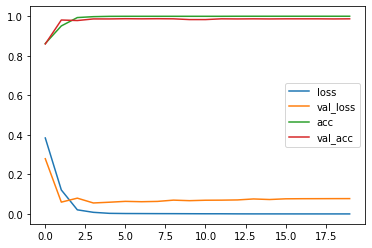

In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

# Unfortunately this URL doesn't work directly with pd.read_csv
# !wget -nc https://lazyprogrammer.me/course_files/spam.csv

!wget https://lazyprogrammer.me/course_files/spam.csv

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

df.head()

# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

df.head()

# rename columns to something better
df.columns = ['labels', 'data']

df.head()

# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

# split up the data
X_train, X_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

tokenizer

# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=20,
  validation_data=(data_test, Ytest)
)

# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()